# Deep Learning for Market Movement Prediction

### Use sklearn's neural_network.MLPClassifier

In [2]:
import os
import random
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
# Construct the training data as a DataFrame
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1]) 
data = pd.DataFrame({'hours': hours, 'success': success})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hours    20 non-null     float64
 1   success  20 non-null     int32  
dtypes: float64(1), int32(1)
memory usage: 368.0 bytes


In [4]:
from sklearn.neural_network import MLPClassifier

In [6]:
model = MLPClassifier(hidden_layer_sizes=[32],
                     max_iter=1000, random_state=100)
model.fit(data['hours'].values.reshape(-1, 1), data['success'])
data['prediction'] = model.predict(data['hours'].values.reshape(-1, 1))

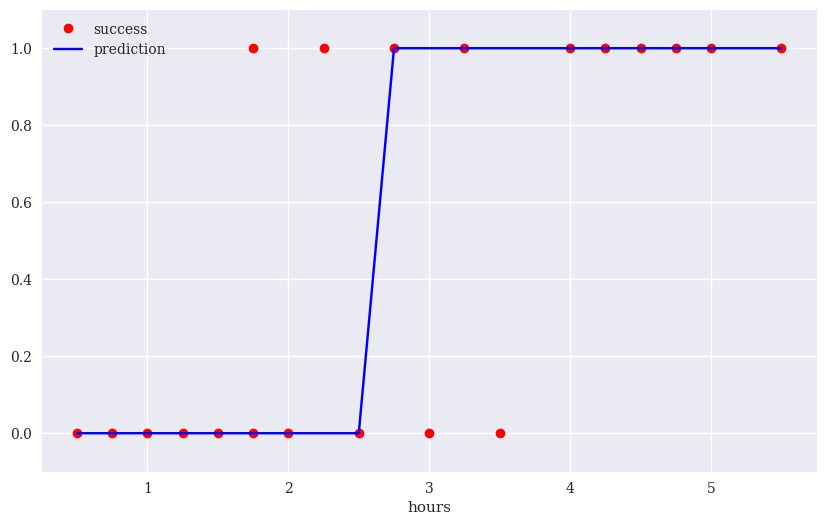

In [7]:
data.plot(x='hours', y=['success', 'prediction'],
          style=['ro', 'b-'], ylim=[-.1, 1.1],
          figsize=(10, 6));

### Use keras' DNN

In [11]:
raw = pd.read_csv('../data/pyalgo_eikon_eod_data.csv',
                 index_col=0, parse_dates=True).dropna()
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [13]:
data.tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.000090,1,0.000722,-0.003784,0.000810,-0.003414,0.000628
2019-12-26,1.1096,0.000811,1,0.000090,0.000722,-0.003784,0.000810,-0.003414
2019-12-27,1.1175,0.007094,1,0.000811,0.000090,0.000722,-0.003784,0.000810
2019-12-30,1.1197,0.001967,1,0.007094,0.000811,0.000090,0.000722,-0.003784
2019-12-31,1.1210,0.001160,1,0.001967,0.007094,0.000811,0.000090,0.000722


In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [15]:
optimizer = Adam(learning_rate=0.0001)

In [16]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
cutoff = '2017-12-31'
# training set
training_data = data[data.index < cutoff].copy()
# Gaussian normalization
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
# test set
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [18]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

Wall time: 13.3 s


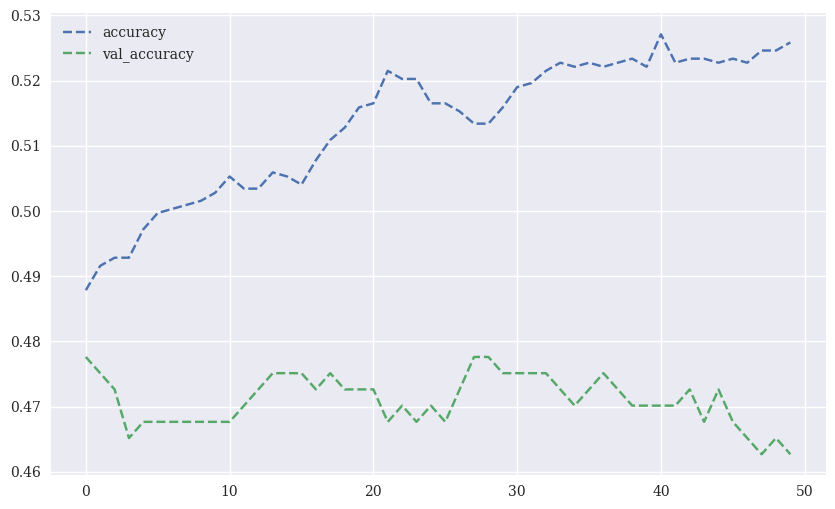

In [23]:
res = pd.DataFrame(model.history.history)
# accuracy is for the training set
# val_accuracy indicates the accuracy of the predictions of a randomly separated validation set after each training period.
# https://www.researchgate.net/publication/341269103_A_deep_learning_approach_to_prepare_participants_for_negotiations_by_recognizing_emotions_with_voice_analysis#pf7
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

### Check the performance on the training data

In [24]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 [==============================] - 0s 4ms/step - loss: 0.7572 - accuracy: 0.5132


[0.757215142250061, 0.5132037997245789]

In [25]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

63/63 [==============================] - 0s 2ms/step


In [26]:
pred[:30].flatten()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0])

In [27]:
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    1.253309
dtype: float64

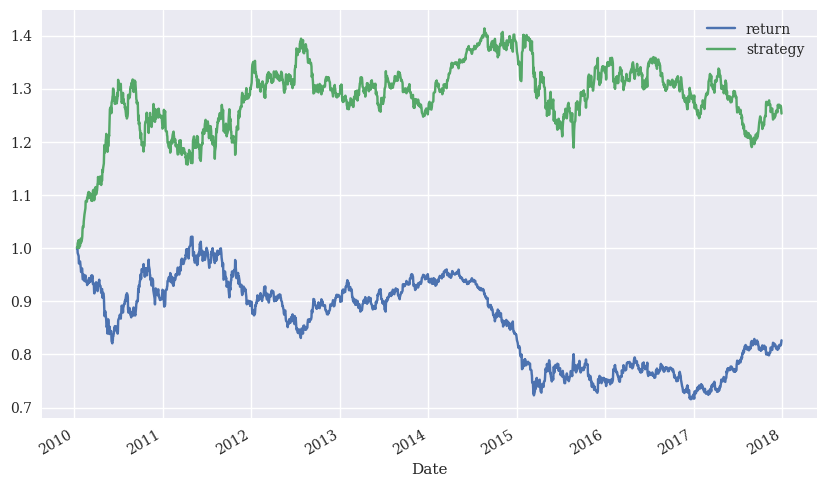

In [28]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

### Check the performance on the testing data

In [29]:
model.evaluate(test_data_[cols], test_data['direction'])
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 [==============================] - 0s 2ms/step


In [30]:
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()

-1    363
 1    140
Name: prediction, dtype: int64

In [32]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.120607
dtype: float64

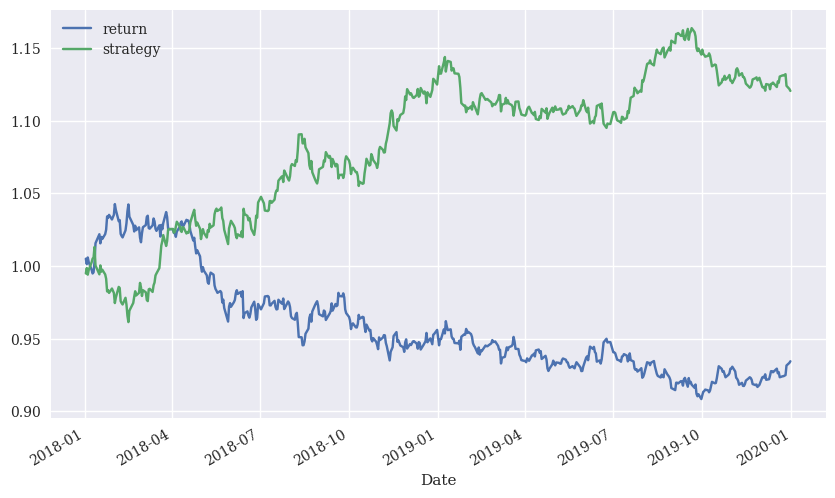

In [33]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

### Adding different types of features

### Momentum

In [40]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)

### Volatility

In [41]:
data['volatility'] = data['return'].rolling(20).std().shift(1)

### Distance between spot and moving average

In [42]:
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)

In [43]:
data.dropna(inplace=True)
cols.extend(['momentum', 'volatility', 'distance'])
print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [44]:
# training set
training_data = data[data.index < cutoff].copy()
# Gaussian normalization
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
# test set
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [45]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 6 s


### Check performance on training data

In [47]:
model.evaluate(training_data_[cols], training_data['direction'])

61/61 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5746


[0.6816142201423645, 0.5745999217033386]

In [48]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

61/61 [==============================] - 0s 2ms/step


In [49]:
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.902498
strategy    3.275759
dtype: float64

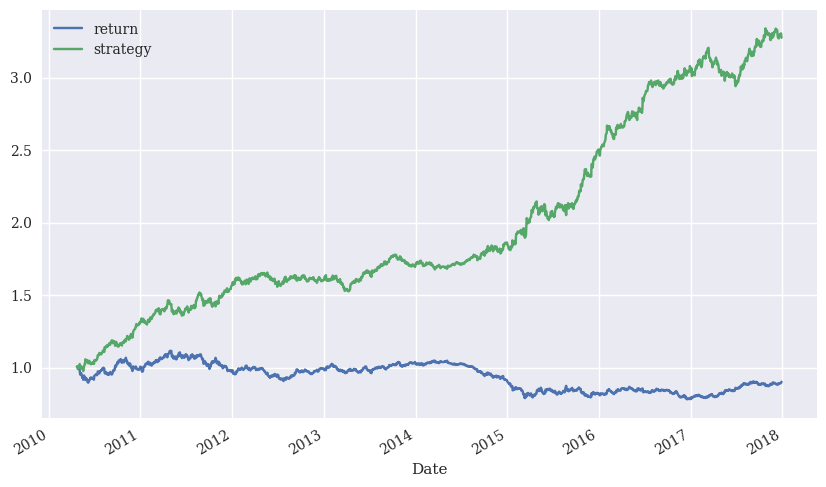

In [50]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

### Check performance on test data

In [51]:
model.evaluate(test_data_[cols], test_data['direction'])
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 [==============================] - 0s 2ms/step


In [52]:
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()

-1    309
 1    194
Name: prediction, dtype: int64

In [53]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.091969
dtype: float64

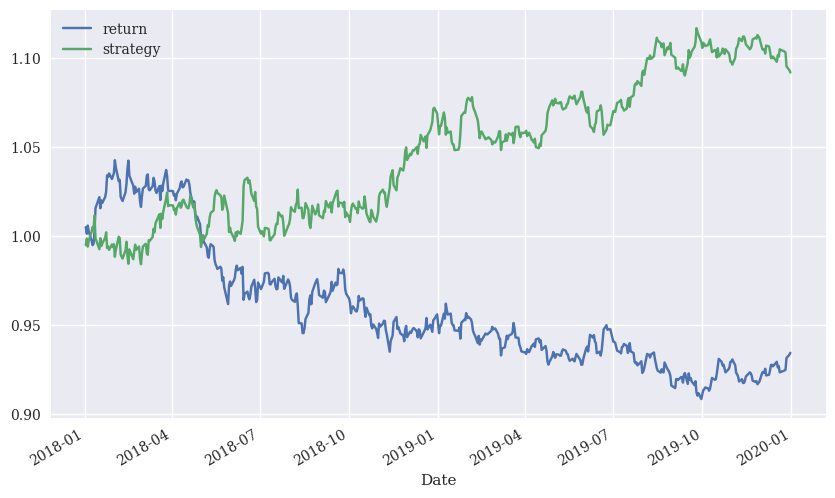

In [54]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));